In [1]:
#This is for ML_Ex4

In [143]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy import optimize as opt
import scipy.io
import random

In [166]:
#InputData image & weights
input_data = scipy.io.loadmat(r"C:\Users\Yow-Gwo Wang\Desktop\ML\machine-learning-ex4\machine-learning-ex4\ex4\ex4data1.mat")
weights = scipy.io.loadmat(r"C:\Users\Yow-Gwo Wang\Desktop\ML\machine-learning-ex4\machine-learning-ex4\ex4\ex4weights.mat")

In [167]:
#To display image in nxn tile
def displayData(X):
    example_width = int(np.sqrt(X.shape[1]))
    example_height = int(np.sqrt(X.shape[1]))
    display_rows = int(np.sqrt(X.shape[0]))
    display_cols = int(np.sqrt(X.shape[0]))
    display_array = np.ones((example_height*display_rows, example_width*display_cols))
    count = 0
    for row in range(display_rows):
        for col in range(display_cols):
            to_plot = X[count]
            pic_max = np.max(to_plot)
            a = to_plot.reshape((example_width, example_height))/pic_max
            a = a.transpose()
            display_array[(row)*example_width:(row+1)*example_width,col*example_height:(col+1)*example_height ] = a
            count = count+1
    plt.imshow(display_array)

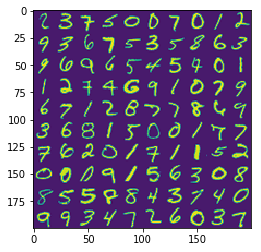

In [168]:
to_select = random.sample(range(1, 5001), 100)
to_display = input_data['X'][to_select]
displayData(to_display)

In [169]:
#Verify the shape of theta and input data
theta1 = weights['Theta1']
theta2 = weights['Theta2']
print(theta1.shape)
print(theta2.shape)
input_X = input_data['X']
input_Y = input_data['y']
print(input_X.shape)
print(input_Y.shape)

(25, 401)
(10, 26)
(5000, 400)
(5000, 1)


In [170]:
def sigmoid(x):
    g = 1/(1 + np.exp(-x))
    return g

In [171]:
def sigmoidGradient(z):
    a = sigmoid(z)
    to_add = np.ones((1,1))
    a_prime = np.vstack([np.ones((1,1)), a])
    g_grad = np.multiply(a_prime,(1-a_prime))
    return g_grad

In [173]:
#NN cost function to return cost only
#only using forward propogation
def nnCostFunction(nn_params, num_labels, X, Y, lamdba):
    #Load the entire X matrix in, then do the calulation 1 by 1.
    #Useful values
    m = X.shape[0]
    X = np.column_stack([np.ones((m, 1)), X])
    Theta1 = nn_params['Theta1']
    Theta2 = nn_params['Theta2']
    J = 0
    grad = 0
    
    for idx in range(m):
        image = np.matrix(X[idx])
        #based on the output Y
        #assign the corresponding y_vec element to 1
        #y has the following range:
        #1~10
        #FYI, for the interpretatoin we will call y = 10 as 0 for the image.
        y = Y[idx]
        y_vec = np.zeros((num_labels,1))
        y_vec[y-1] = 1
        #X is 1x400 -> 1x401
        #1st layer using Theta1:
        #Theta1: 25*401
        #X_prime: 1x401 -> transpose: 401x1   
        z2 = np.dot(Theta1, image.transpose())
        a2 = sigmoid(z2)
        #2nd layer using Theta2
        #a2 is 25 x1 -> 26 x1
        #Theta_2 is 10x26    
        to_add = np.ones((1,1))
        a2_prime = np.vstack([np.ones((1,1)), a2])
        z3 = np.dot(Theta2, a2_prime)
        a3 = sigmoid(z3)
        b = np.multiply((-y_vec), np.log(a3))- np.multiply((1-y_vec),np.log(1-a3))
        J = J + b.sum()   
    #Calculate the regularization from Theta
    #Do not include the bias term's theta in it -> first column of Theta
    reg_theta1 = lamdba/(2*m)*(np.square(Theta1).sum() - np.square(Theta1[:, 0]).sum())
    reg_theta2 = lamdba/(2*m)*(np.square(Theta2).sum() - np.square(Theta2[:, 0]).sum())
    J = 1/m*J + reg_theta1 + reg_theta2
    return J


In [174]:
#Consider regularization or not
no_reg_ans = nnCostFunction(weights, 10, input_X, input_Y, 0)
reg_ans = nnCostFunction(weights, 10, input_X, input_Y, 3)
print('No regularization: ')
print(no_reg_ans)
print('Include regularization: ')
print(reg_ans)

No regularization: 
0.2876291651613188
Include regularization: 
0.576051246950133


In [177]:
#Support function
#to randomnly generate theta within a certain initial value
def randInitializeWeights(L_in, L_out):
    epsilon_init = 0.12
    W = np.zeros((L_out, L_in+1))
    W = np.random.rand(L_out, L_in+1)*2*epsilon_init - epsilon_init
    return W

In [178]:
#support function
#to do gradiant check
def computeNumericalGradient(theta, input_X, input_Y, lamdba):

#COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
#and gives us a numerical estimate of the gradient.
#numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
#gradient of the function J around theta. Calling y = J(theta) should
#return the function value at theta.

#Notes: The following code implements numerical gradient checking, and 
#        returns the numerical gradient.It sets numgrad(i) to (a numerical 
#        approximation of) the partial derivative of J with respect to the 
#        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
#        be the (approximately) the partial derivative of J with respect 
#        to theta(i).)
                
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4;
    for p in range(theta.shape[0]):
        #Set perturbation vector
        perturb[p] = e;
        loss1, n1 = nnCostFunction2(theta - perturb, 3, 5, 3, input_X, input_Y, lamdba)
        loss2, n1 = nnCostFunction2(theta + perturb, 3, 5, 3, input_X, input_Y, lamdba)
        #Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
    return numgrad

In [179]:
#support function
#used to do gradiant checek
def debugInitializeWeights(fan_out, fan_in):
#DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
#incoming connections and fan_out outgoing connections using a fixed
#strategy, this will help you later in debugging
#   W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights 
#   of a layer with fan_in incoming connections and fan_out outgoing 
#   connections using a fix set of values
#
#   Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
#   the first row of W handles the "bias" terms
#

# Set W to zeros
    W = np.ones((fan_out, 1 + fan_in))

# Initialize W using "sin", this ensures that W is always of the same
# values and will be useful for debugging
    W = np.reshape(np.sin(np.linspace(1, W.size,num=W.size)), W.shape) / 10

    return W

In [183]:
#core function, doing forward and back propogation to calculate the cost and the derivative of the cost
def nnCostFunction2(nn_params, num_labels, hidden_layer_size, input_layer_size ,X, Y, lamdba):
    #Load the entire X matrix in, then do the calulation 1 by 1.
    #Useful values
    m = X.shape[0]
    X = np.column_stack([np.ones((m, 1)), X])
    Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)))
    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):], (num_labels, (hidden_layer_size + 1)))
    J = 0
    
    Delta2 = np.zeros(Theta2.shape)
    Delta1 = np.zeros(Theta1.shape)
    #print(Delta1.shape)
    for idx in range(m):
##################################################################################
        #forward propogation
        image = np.matrix(X[idx])
        #based on the output Y
        #assign the corresponding y_vec element to 1
        #y has the following range:
        #1~10
        #FYI, for the interpretatoin we will call y = 10 as 0 for the image.
        y = Y[idx]
        y_vec = np.zeros((num_labels,1))
        y_vec[y-1] = 1
        #X is 1x400 -> 1x401
        #1st layer using Theta1:
        #Theta1: 25*401
        #X_prime: 1x401 -> transpose: 401x1   
        z2 = np.dot(Theta1, image.transpose())
        a2 = sigmoid(z2)
        #2nd layer using Theta2
        #a2 is 25 x1 -> 26 x1
        #Theta_2 is 10x26    
        to_add = np.ones((1,1))
        a2_prime = np.vstack([np.ones((1,1)), a2])
        z3 = np.dot(Theta2, a2_prime)
        a3 = sigmoid(z3)
        b = np.multiply((-y_vec), np.log(a3))- np.multiply((1-y_vec),np.log(1-a3))
        J = J + b.sum()   
###########################################################################
        #back propogation
        delta3 = a3 - y_vec
        Delta2 = Delta2 + np.dot(delta3,np.transpose(a2_prime))

        firstHalf = np.dot(np.transpose(Theta2),delta3)
        delta2 = np.multiply(firstHalf,sigmoidGradient(z2))
        Delta1 = Delta1 + np.dot(delta2[1:,:],image)
###########################################################################
    #Calculate the regularization from Theta for cost function
    #Do not include the bias term's theta in it -> first column of Theta
    reg_theta1 = lamdba/(2*m)*(np.square(Theta1).sum() - np.square(Theta1[:, 0]).sum())
    reg_theta2 = lamdba/(2*m)*(np.square(Theta2).sum() - np.square(Theta2[:, 0]).sum())
    J = 1/m*J + reg_theta1 + reg_theta2
###########################################################################
    #Calculate the regularization from Theta for the derivative of the cost function
    #Do not include the bias term's theta in it -> first column of Theta
    Theta1_grad = 1/m*Delta1
    Theta2_grad = 1/m*Delta2
    Theta1_grad[:,1:] = 1/m*Delta1[:,1:] + lamdba/m*Theta1[:,1:]
    Theta2_grad[:,1:] = 1/m*Delta2[:,1:] + lamdba/m*Theta2[:,1:]
    grad = np.concatenate((np.ravel(Theta1_grad), np.ravel(Theta2_grad)))

    return J, grad


In [188]:
#Do gradient check
#To verify the Back propagation has correct implementation
input_layer_size = 3
hidden_layer_size = 5
num_labels = 3
m = 5

#We generate some 'random' test data
Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
#Reusing debugInitializeWeights to generate X
X  = debugInitializeWeights(m, input_layer_size - 1)
y  = 1 + np.remainder(range(m), num_labels)

input_theta = np.concatenate((Theta1.flatten(), Theta2.flatten()), axis=0)
input_theta.shape
J, grad = nnCostFunction2(input_theta, 3, 5, 3, X, y, 3)
numgrad = computeNumericalGradient(input_theta,X, y, 3)
print('Verfity checkNNGradients')

dTheta1_numgrad = np.reshape(numgrad[0:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)))
dTheta1_grad = np.reshape(grad[0:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)))

print('dTheta1 \n')
print(dTheta1_numgrad)
print(dTheta1_grad)

dTheta2_numgrad = np.reshape(numgrad[(hidden_layer_size * (input_layer_size + 1)):], (num_labels, (hidden_layer_size + 1)))
dTheta2_grad = np.reshape(grad[(hidden_layer_size * (input_layer_size + 1)):], (num_labels, (hidden_layer_size + 1)))

print('\ndTheta2 \n')
print(dTheta2_numgrad)
print(dTheta2_grad)



Verfity checkNNGradients
dTheta1 

[[ 0.01272203  0.05471668  0.00868489 -0.04533175]
 [ 0.00646352 -0.01674143  0.03938178  0.05929756]
 [-0.005742   -0.03277532 -0.06025856 -0.03234036]
 [-0.01267924  0.05926853  0.03877546 -0.01736759]
 [-0.00794574 -0.04510686  0.00898998  0.05482148]]
[[ 0.01272203  0.05471668  0.00868489 -0.04533175]
 [ 0.00646352 -0.01674143  0.03938178  0.05929756]
 [-0.005742   -0.03277532 -0.06025856 -0.03234036]
 [-0.01267924  0.05926853  0.03877546 -0.01736759]
 [-0.00794574 -0.04510686  0.00898998  0.05482148]]

dTheta2 

[[ 0.10934772  0.11135436  0.06099703  0.00994614 -0.00160637  0.03558854]
 [ 0.108133    0.11609346  0.0761714   0.02218834 -0.00430676  0.01898519]
 [ 0.30627037  0.21889958  0.18458753  0.13942633  0.09836012  0.10071231]]
[[ 0.10934772  0.11135436  0.06099703  0.00994614 -0.00160637  0.03558854]
 [ 0.108133    0.11609346  0.0761714   0.02218834 -0.00430676  0.01898519]
 [ 0.30627037  0.21889958  0.18458753  0.13942633  0.09836012  0.1

In [211]:
#use optimizer from the library to calculate the weghts using our nnCostFunciton2 (with back propogation)
initial_Theta1 = randInitializeWeights(400, 25)
initial_Theta2 = randInitializeWeights(25, 10)
input_theta = np.concatenate((initial_Theta1.flatten(), initial_Theta2.flatten()), axis=0)
fmin = opt.minimize(fun=nnCostFunction2, x0=input_theta, args=(10, 25, 400, input_X, input_Y, 5), 
                method='TNC', jac=True, options={'maxiter': 100})
fmin

     fun: 0.9314069235256304
     jac: array([ 1.08255502e-04,  4.33277584e-05, -2.72833443e-05, ...,
       -9.90791016e-06,  2.07875068e-03, -2.57639514e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 100
     nit: 12
  status: 3
 success: False
       x: array([ 0.65312283,  0.04332776, -0.02728334, ..., -1.06818464,
       -1.29571057, -0.62182803])

In [159]:
def predict(Theta1, Theta2, X):
    #Load the entire X matrix in, then do the calulation 1 by 1.
    #Useful values
    m = X.shape[0]
    p = np.zeros(m)
    X = np.column_stack([np.ones((m, 1)), X])
    for idx in range(m):
        image = np.matrix(X[idx])
        #X is 1x400 -> 1x401
        #1st layer using Theta1:
        #Theta1: 25*401
        #X_prime: 1x401 -> transpose: 401x1   
        z2 = np.dot(Theta1, image.transpose())
        a2 = sigmoid(z2)
        #2nd layer using Theta2
        #a2 is 25 x1 -> 26 x1
        #Theta_2 is 10x26    
        to_add = np.ones((1,1))
        a2_prime = np.vstack([np.ones((1,1)), a2])
        z3 = np.dot(Theta2, a2_prime)
        a3 = sigmoid(z3)
        p[idx] = np.argmax(a3, axis=0)+1
    return p


In [212]:
#Verify the results using the weights calculate by our cost function using lambda=5 and maxiter=100
theta1 = np.matrix(np.reshape(fmin.x[:25 * (400 + 1)], (25, (400 + 1))))
theta2 = np.matrix(np.reshape(fmin.x[25 * (400 + 1):], (10, (25 + 1))))
p = predict(theta1, theta2, input_X)

correct = [1 if a == b else 0 for (a, b) in zip(p, input_Y)]
accuracy = sum(correct)/ float(len(correct))
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 93.26%


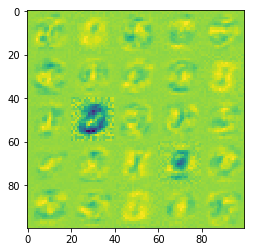

In [213]:
#visualizing the hidden layer
displayData(theta1[:, 1:])


In [163]:
def display1Data(X):
    X = X.reshape(20, 20).transpose()
    plt.imshow(X)
    plt.show()

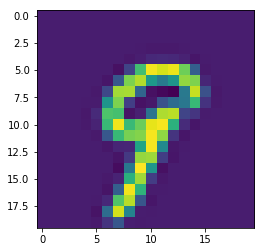

Neural Network Prediction: 9
y output is: 9


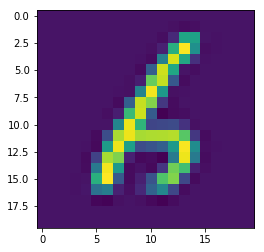

Neural Network Prediction: 6
y output is: 6


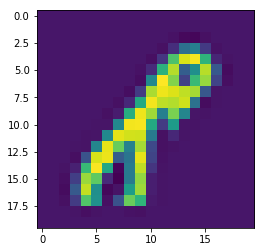

Neural Network Prediction: 8
y output is: 8


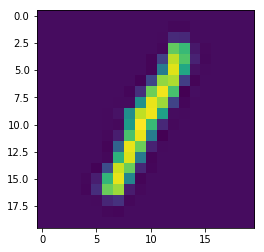

Neural Network Prediction: 1
y output is: 1


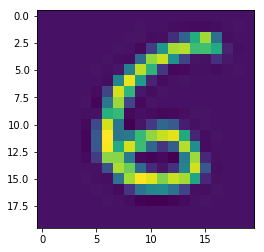

Neural Network Prediction: 6
y output is: 6


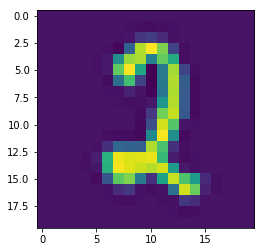

Neural Network Prediction: 2
y output is: 2


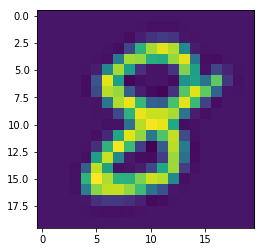

Neural Network Prediction: 8
y output is: 8


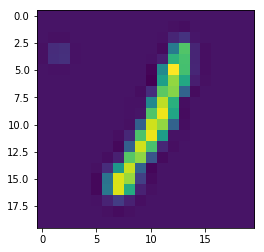

Neural Network Prediction: 1
y output is: 1


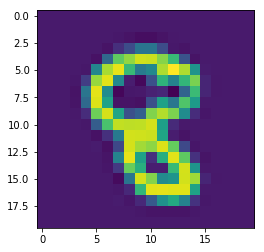

Neural Network Prediction: 8
y output is: 8


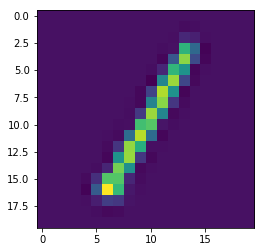

Neural Network Prediction: 1
y output is: 1


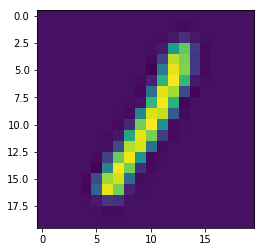

Neural Network Prediction: 1
y output is: 1


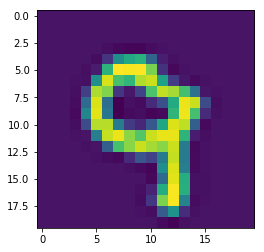

Neural Network Prediction: 9
y output is: 9


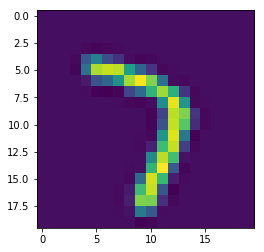

Neural Network Prediction: 7
y output is: 7


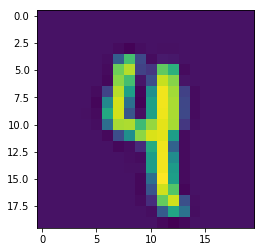

Neural Network Prediction: 4
y output is: 4


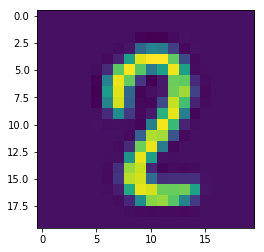

Neural Network Prediction: 2
y output is: 2


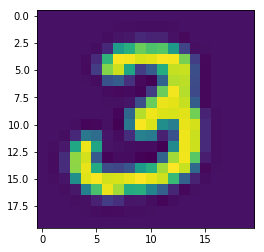

Neural Network Prediction: 3
y output is: 3


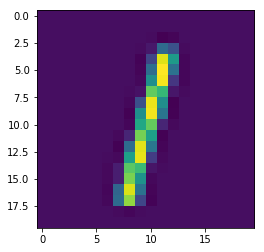

Neural Network Prediction: 1
y output is: 1


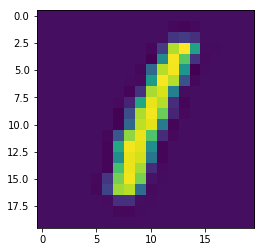

Neural Network Prediction: 1
y output is: 1


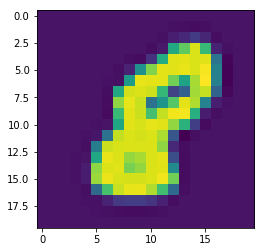

Neural Network Prediction: 8
y output is: 8


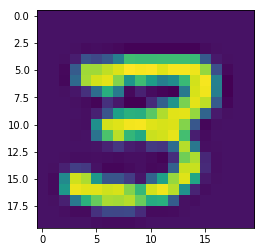

Neural Network Prediction: 3
y output is: 3


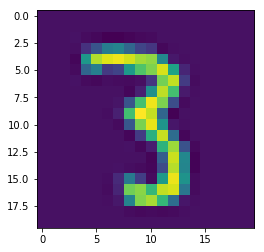

Neural Network Prediction: 3
y output is: 3


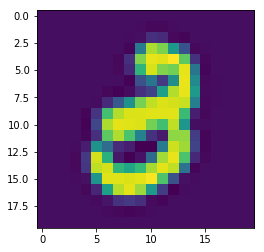

Neural Network Prediction: 3
y output is: 3


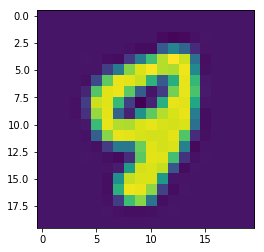

Neural Network Prediction: 9
y output is: 9


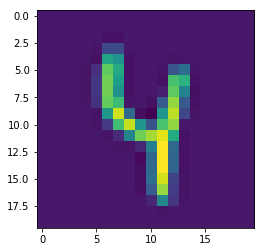

Neural Network Prediction: 4
y output is: 4


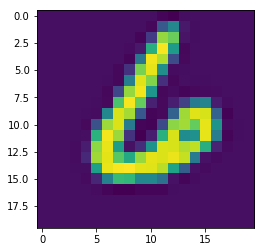

Neural Network Prediction: 6
y output is: 6


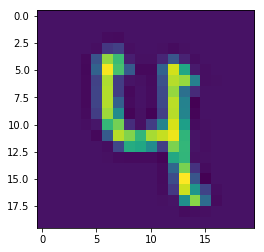

Neural Network Prediction: 4
y output is: 4


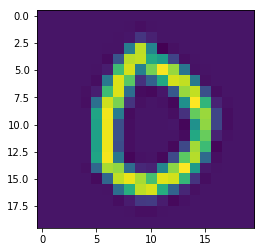

Neural Network Prediction: 0
y output is: 0


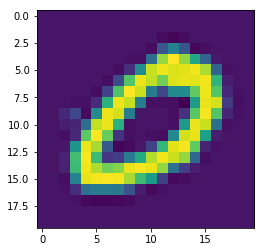

Neural Network Prediction: 0
y output is: 0


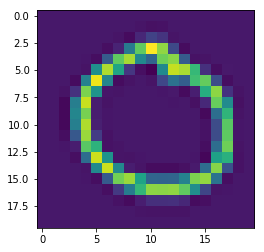

Neural Network Prediction: 0
y output is: 0


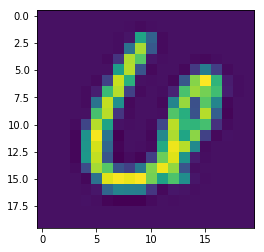

Neural Network Prediction: 0
y output is: 6


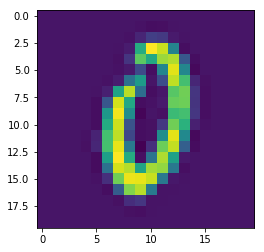

Neural Network Prediction: 0
y output is: 0


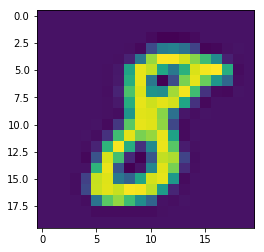

Neural Network Prediction: 8
y output is: 8


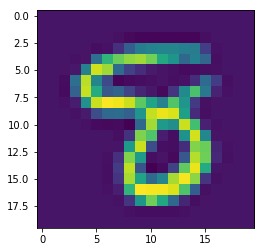

Neural Network Prediction: 8
y output is: 8


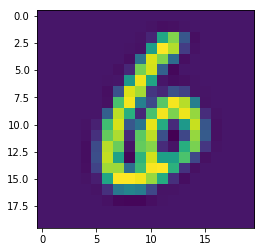

Neural Network Prediction: 6
y output is: 6


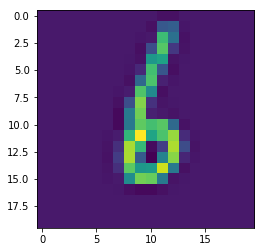

Neural Network Prediction: 6
y output is: 6


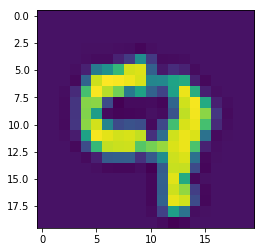

Neural Network Prediction: 9
y output is: 9


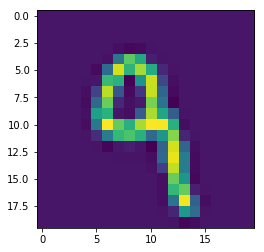

Neural Network Prediction: 9
y output is: 9


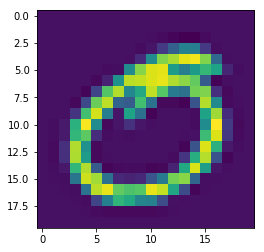

Neural Network Prediction: 0
y output is: 0


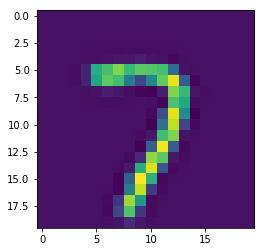

Neural Network Prediction: 7
y output is: 7


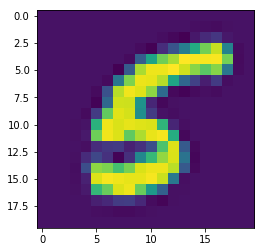

Neural Network Prediction: 5
y output is: 5


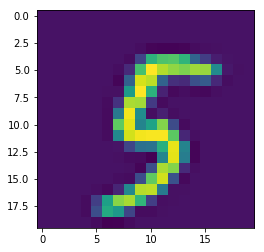

Neural Network Prediction: 5
y output is: 5


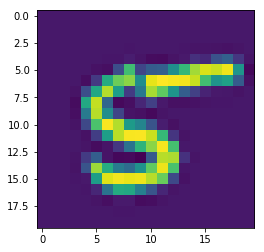

Neural Network Prediction: 5
y output is: 5


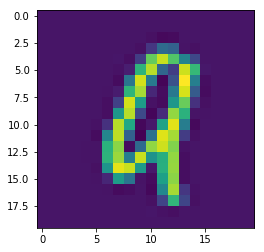

Neural Network Prediction: 9
y output is: 9


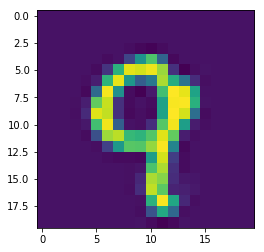

Neural Network Prediction: 9
y output is: 9


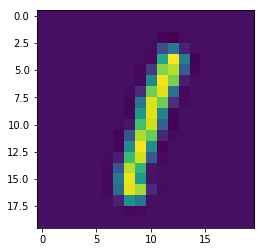

Neural Network Prediction: 1
y output is: 1


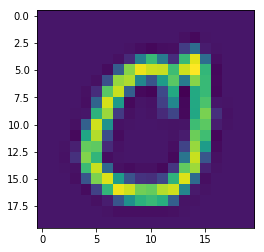

Neural Network Prediction: 0
y output is: 0


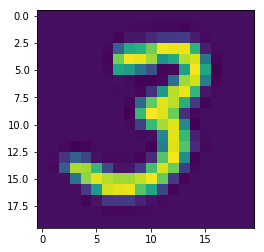

Neural Network Prediction: 3
y output is: 3


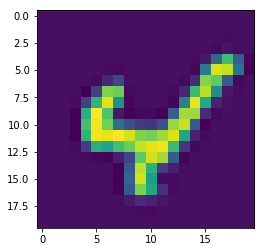

Neural Network Prediction: 4
y output is: 4


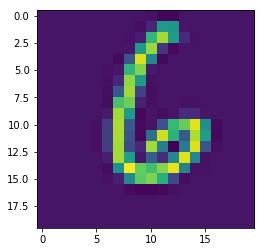

Neural Network Prediction: 6
y output is: 6


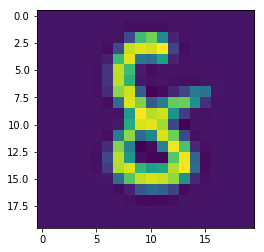

Neural Network Prediction: 8
y output is: 8


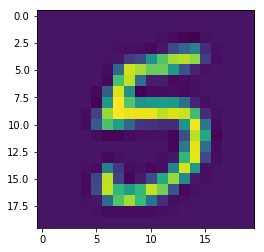

Neural Network Prediction: 5
y output is: 5


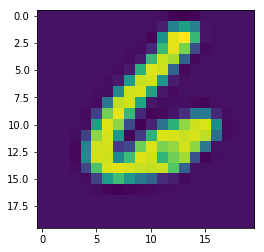

Neural Network Prediction: 6
y output is: 6


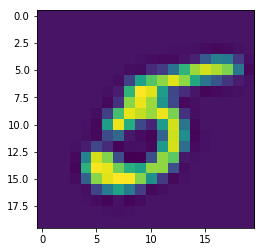

Neural Network Prediction: 5
y output is: 5


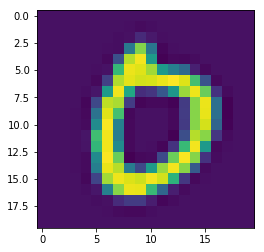

Neural Network Prediction: 0
y output is: 0


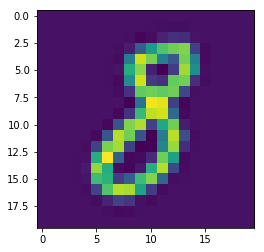

Neural Network Prediction: 8
y output is: 8


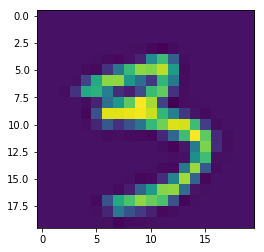

Neural Network Prediction: 3
y output is: 3


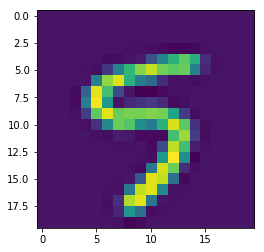

Neural Network Prediction: 5
y output is: 5


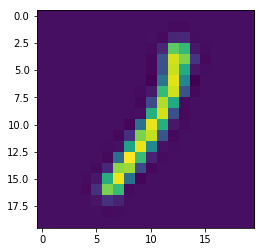

Neural Network Prediction: 1
y output is: 1


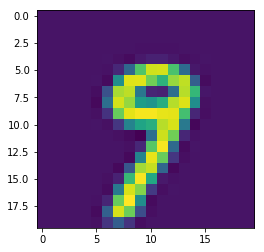

Neural Network Prediction: 9
y output is: 9


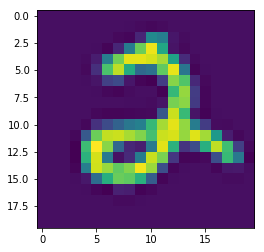

Neural Network Prediction: 2
y output is: 2


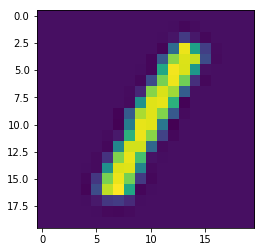

Neural Network Prediction: 1
y output is: 1


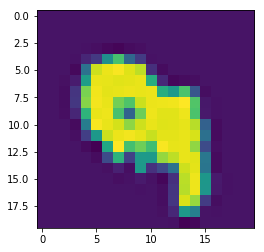

Neural Network Prediction: 9
y output is: 9


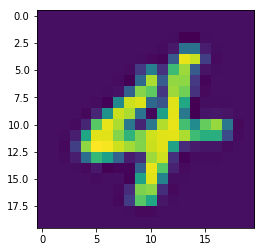

Neural Network Prediction: 4
y output is: 4


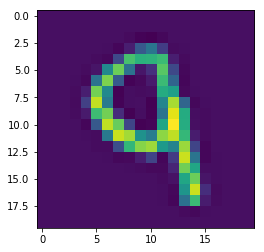

Neural Network Prediction: 9
y output is: 9


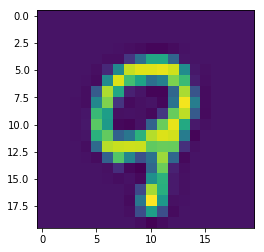

Neural Network Prediction: 9
y output is: 9


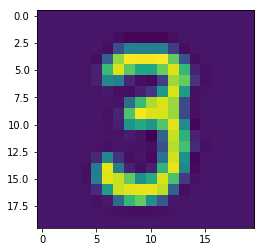

Neural Network Prediction: 3
y output is: 3


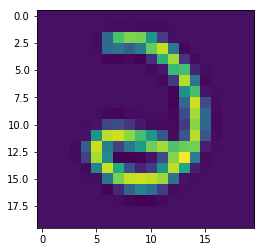

Neural Network Prediction: 2
y output is: 2


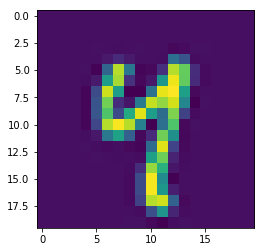

Neural Network Prediction: 4
y output is: 4


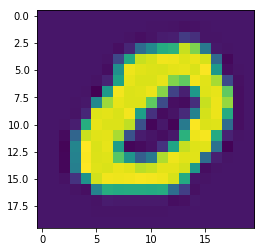

Neural Network Prediction: 0
y output is: 0


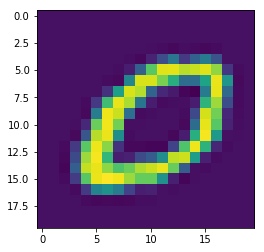

Neural Network Prediction: 0
y output is: 0


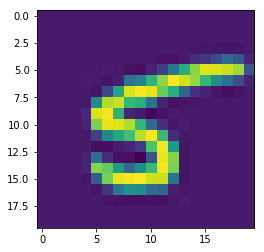

Neural Network Prediction: 5
y output is: 5


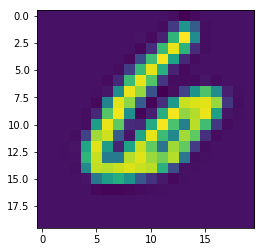

Neural Network Prediction: 6
y output is: 6


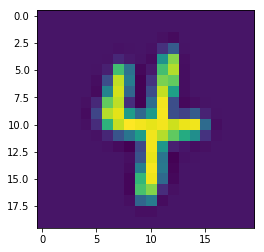

Neural Network Prediction: 4
y output is: 4


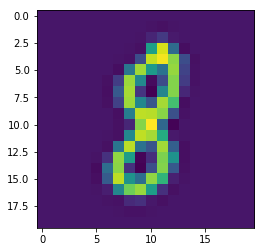

Neural Network Prediction: 8
y output is: 8


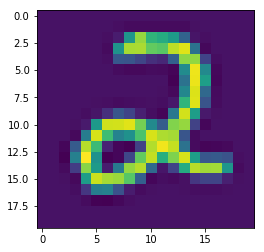

Neural Network Prediction: 2
y output is: 2


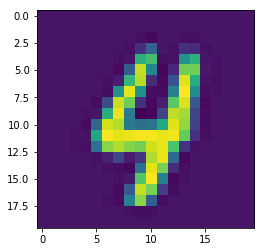

Neural Network Prediction: 4
y output is: 4


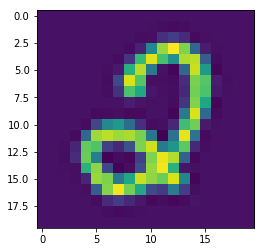

Neural Network Prediction: 2
y output is: 2


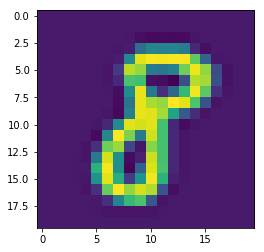

Neural Network Prediction: 8
y output is: 8


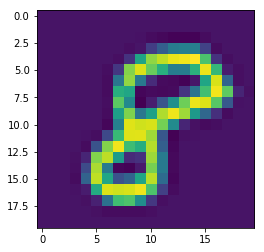

Neural Network Prediction: 8
y output is: 8


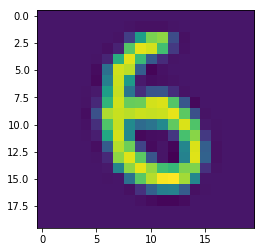

Neural Network Prediction: 6
y output is: 6


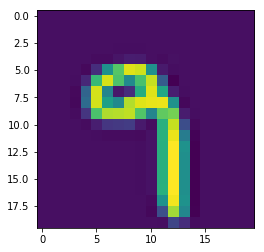

Neural Network Prediction: 9
y output is: 9


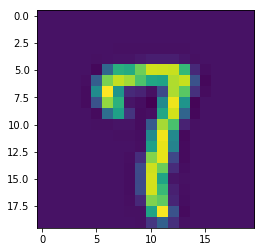

Neural Network Prediction: 7
y output is: 7


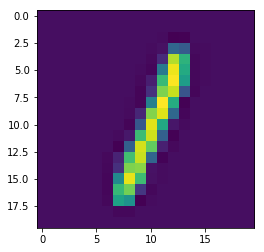

Neural Network Prediction: 1
y output is: 1


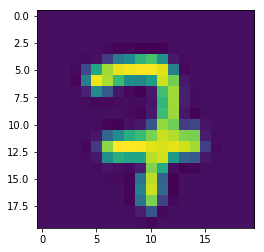

Neural Network Prediction: 7
y output is: 7


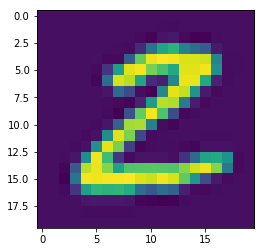

Neural Network Prediction: 2
y output is: 2


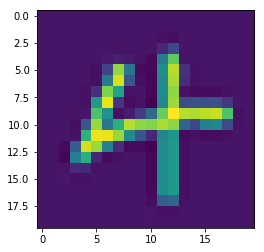

Neural Network Prediction: 4
y output is: 4


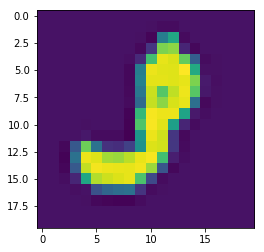

Neural Network Prediction: 3
y output is: 3


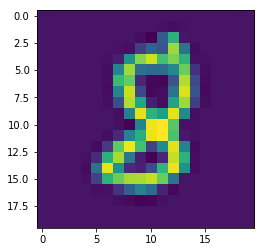

Neural Network Prediction: 8
y output is: 8


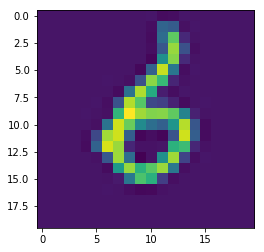

Neural Network Prediction: 6
y output is: 6


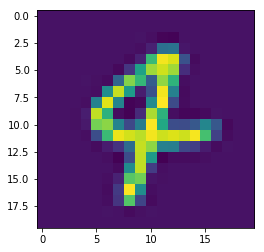

Neural Network Prediction: 4
y output is: 4


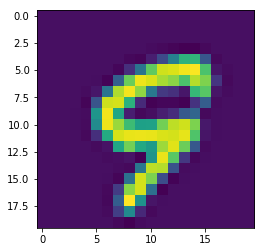

Neural Network Prediction: 9
y output is: 9


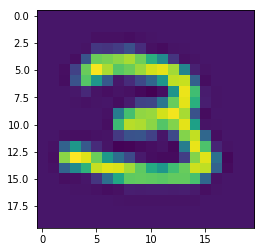

Neural Network Prediction: 3
y output is: 3


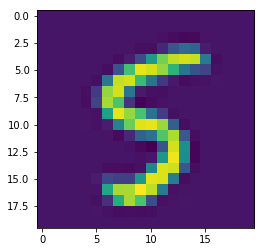

Neural Network Prediction: 5
y output is: 5


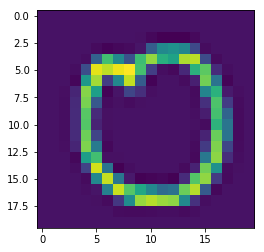

Neural Network Prediction: 0
y output is: 0


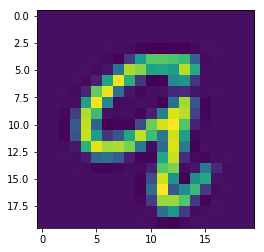

Neural Network Prediction: 9
y output is: 9


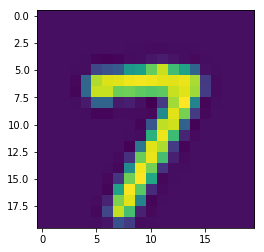

Neural Network Prediction: 7
y output is: 7


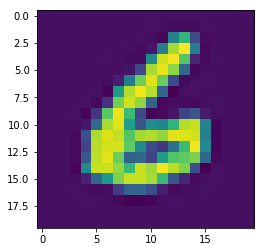

Neural Network Prediction: 6
y output is: 6


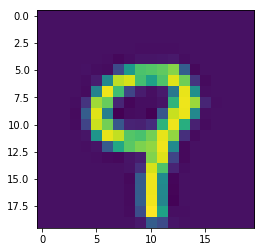

Neural Network Prediction: 9
y output is: 9


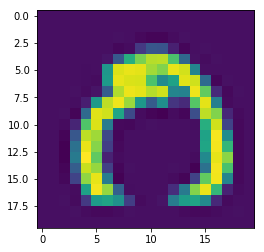

Neural Network Prediction: 0
y output is: 0


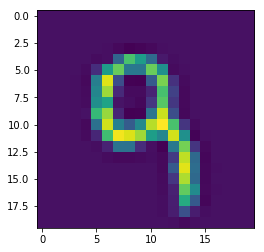

Neural Network Prediction: 9
y output is: 9


In [193]:
#Randomly permute examples to verify the correctnes of the NN-based
#cost function
rp = np.random.permutation(input_X.shape[0])
for i in range(100):
    #Display 
    display1Data(input_X[rp[i], :])
    pred = predict(theta1, theta2, np.matrix(input_X[rp[i],:]))
    if pred == 10:
        pred = 0
    if int(input_Y[rp[i]]) == 10:
        y = 0
    else:
        y = int(input_Y[rp[i]])
    print('Neural Network Prediction: %d' % int(pred))
    print('y output is: %d' % int(y))
    
    


In [214]:
#overfitting issue
#lower lambda and higher iteratoin number to check its prediction results and 
#visualize the hidden layer

#use optimizer from the library to calculate the weghts using our nnCostFunciton2 (with back propogation)
#lambda = 0.1 & maxiter=1000
initial_Theta1 = randInitializeWeights(400, 25)
initial_Theta2 = randInitializeWeights(25, 10)
input_theta = np.concatenate((initial_Theta1.flatten(), initial_Theta2.flatten()), axis=0)
fmin = opt.minimize(fun=nnCostFunction2, x0=input_theta, args=(10, 25, 400, input_X, input_Y, 1), 
                method='TNC', jac=True, options={'maxiter': 500})
fmin

     fun: 0.3143369047856563
     jac: array([-1.49240118e-04,  7.62160454e-10,  2.39096164e-09, ...,
       -9.34665616e-06, -1.89819996e-05, -3.38949085e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 500
     nit: 31
  status: 3
 success: False
       x: array([ 1.87673619e-02,  3.81080227e-06,  1.19548082e-05, ...,
       -1.29443993e+00, -2.64658266e-01,  8.38989095e-01])

In [215]:
#Verify the results using the weights calculate by our cost function using lambda=1 and maxiter=500
theta1 = np.matrix(np.reshape(fmin.x[:25 * (400 + 1)], (25, (400 + 1))))
theta2 = np.matrix(np.reshape(fmin.x[25 * (400 + 1):], (10, (25 + 1))))
p = predict(theta1, theta2, input_X)

correct = [1 if a == b else 0 for (a, b) in zip(p, input_Y)]
accuracy = sum(correct)/ float(len(correct))
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 99.56%


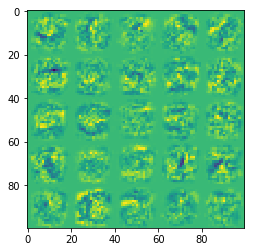

In [216]:
#visualizing the hidden layer
displayData(theta1[:, 1:])
